## Preprocessing RG-CPD example
Example taken from Lorentz workshop; Lorentz_proto/Lorentz_sem.ipynb

To run this notebook you should have an RGCDP environment running and the data in some folder on your computer. The data is available on surfdrive.

Purpose of this example: show how preprocessing is carried out in RG-CPD

General idea of this pipeline: forecast 28 day mean precipitation in East Africa (target) between for the October November December (OND) rainy season from 1981-2021 by correlating SST data at 28 day means 14 day prior to this target.

### load packages

In [21]:
#internal modules
from RGCPD import core_pp
from RGCPD import class_BivariateMI
from RGCPD import class_RGCPD

#libraries
import pandas as pd
import numpy as np

### Set paths to target and precursor

In [22]:
target_path = './data/chrips_1981-2021_target_new_left.nc'
precur_path = './data/era5_sst_1959-2021_1_12_daily_2.0deg.nc'

### Load target
First we load the target netcdf file. Core_pp.import_ds_lazy is just xarray_load.dataset with some extra functionality, such as loading the data in longitude format 'west_east' (-180,180) or 'only_east'(0,360). You can give argument format_lon='west_east' for that.
Usually it is not necessary to convert it to a Pandas dataframe, this happens internally. But in this case we want it for easy lag shifting of the target. (easily solved by the new s2spy calendar ;))

In [23]:
target = core_pp.import_ds_lazy(target_path)
df_target = target['spatial_mean_raw'].to_dataframe()

### Define 'list_of_name_path'
list of name path is a format used by RGCPD for the variable name and the path to the data of that variable. 

Note: in this case we add the dataframe itself, you can also add a path to the target. Often we have a path to an xarray containing clusters with timeseries as a target. Here you would give the path to that dataset with the number of the clustered region.

In [24]:
# define input by filling list_of_name_path: 
# format list_of_name_path = [('TVname', 'TVpath'), ('prec_name', 'prec_path')]
list_of_name_path = [
    ('', df_target.shift(-14)), #here we shift the target 14 days
    ('sst', precur_path)
    ]

### Initiate BivariateMI settings
This is not necessary for preprocessing, but you need to set these settings to initiate the RGCPD instance. The BivariateMI settings define some of the controls for RGDR for every precursor, such as:
- alpha: alpha value for p-values
- FDR_control: False Discovery Rate
- lags: how many lags to use
- distance_eps & min_area_degrees: specific RGDR controls
- lag_as_gap: lag as days in between last day of precursor aggregation window and first day of target window

In [25]:
list_for_MI = [class_BivariateMI.BivariateMI(name='sst', 
                           alpha=.01, FDR_control=True, lags=np.array([1]), 
                           distance_eps=700, min_area_in_degrees2=5, lag_as_gap=False)]

### Initiate RGDR
subseasonal mode

In [26]:
rg = class_RGCPD.RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           tfreq=28, # <- subseasonal forecasting mode, all data will be aggregated to 10-day means
           start_end_TVdate=('10-01', '12-31'), # <- defining target period 
           start_end_year=(1981, 2020), #<- define start and end year of the precursors
           path_outmain='./output_RGCPD')

## Preprocessing


Performing pre-processing sst
sorting longitude
sorting latitude
applying rolling mean, beware: memory intensive
using absolute anomalies w.r.t. climatology of smoothed concurrent day accross years

Visual test latlon -28 160

/Users/jannesvaningen/miniforge3/envs/RGCPD/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,




Start linear detrending ...
Done
Visual test on 4th observation
writing ncdf file to:
./data/preprocessed/era5_sst_1959-2021_1jan_31dec_daily_2.0deg.nc


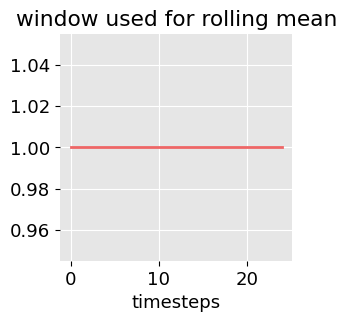

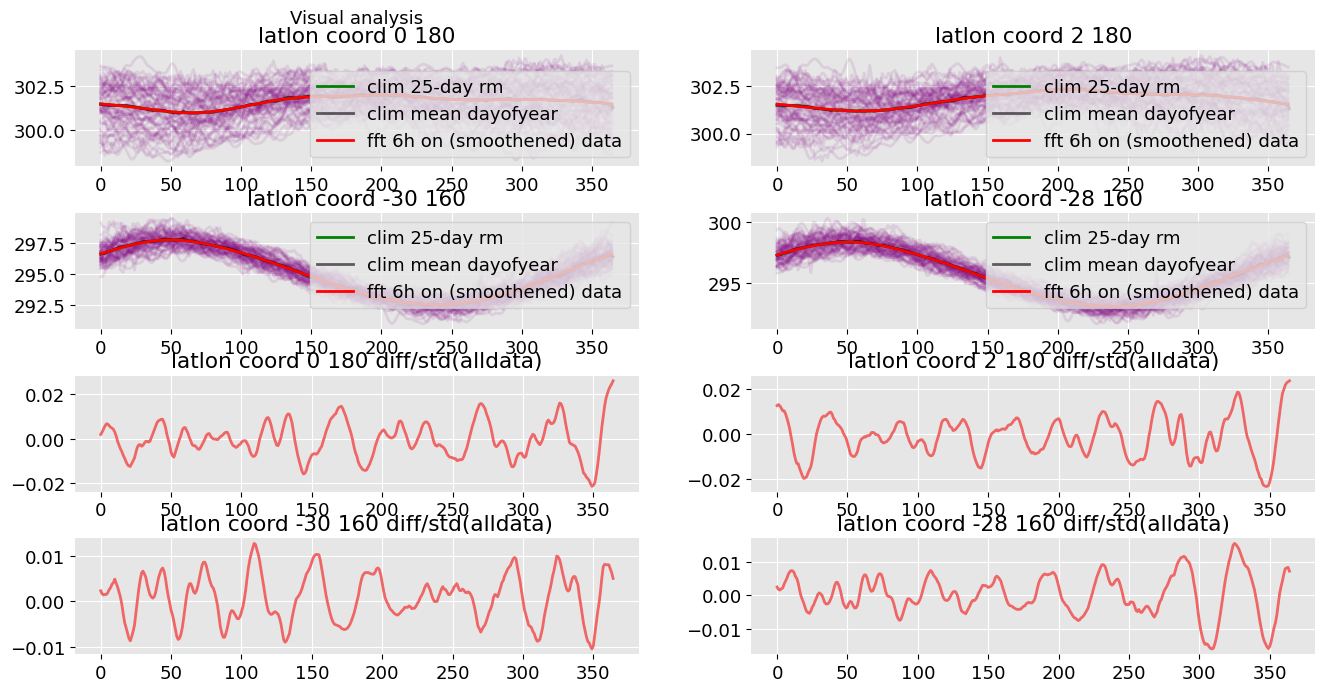

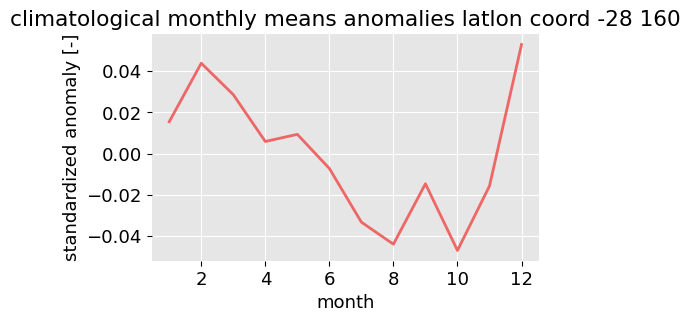

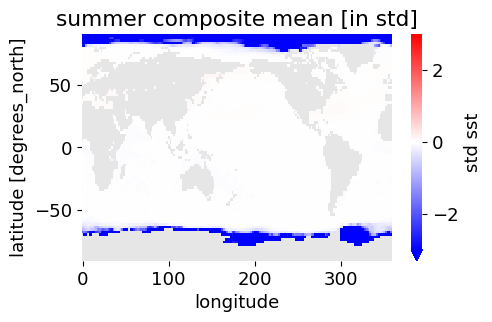

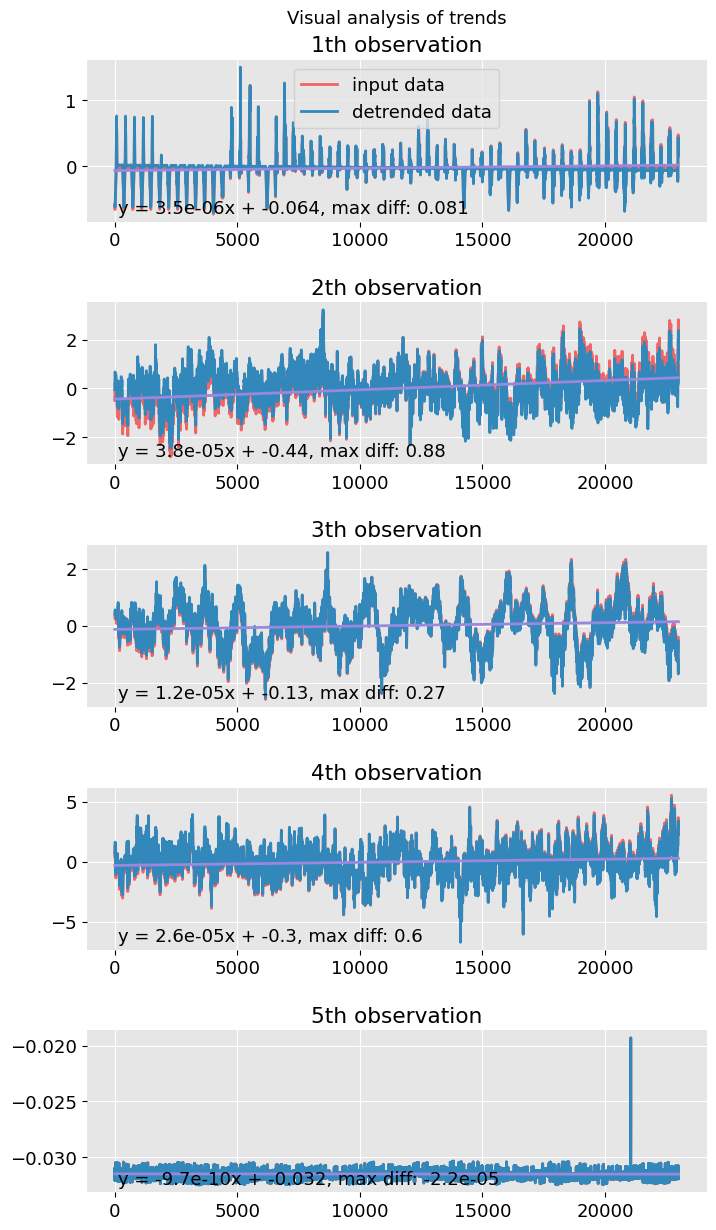

In [27]:
rg.pp_precursors(detrend=True, anomaly=True)

### target variable

Start linear detrending ...
Done
Visual test on 0th observationusing absolute anomalies w.r.t. climatology of smoothed concurrent day accross years
original tfreq of imported response variable is converted to desired 28 (daily) means


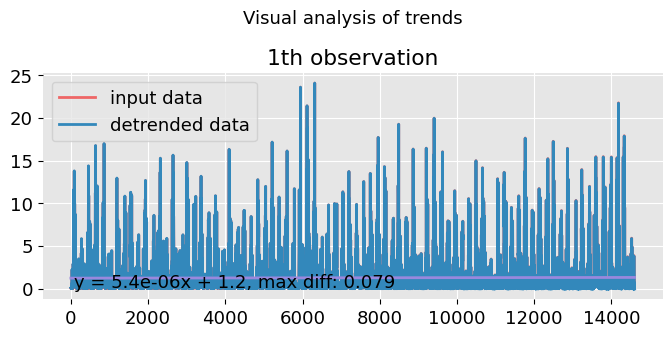

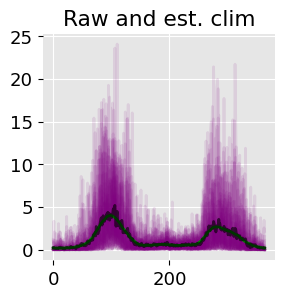

In [28]:
rg.pp_TV(detrend=True, anomaly=True)